In [177]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [178]:
#torch.manual_seed(7)

In [179]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67182/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67182/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [180]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67182/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_67182/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [181]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [182]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []
tacc=[]

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()

    tacc.append(tcorr/ttot)
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 154.87it/s]


Epoch 0/100, Loss: 0.047646284103393555, train dataset accuracy: 52.83
test dataset accuracy: 66.17%


100%|██████████| 235/235 [00:01<00:00, 144.50it/s]


Epoch 1/100, Loss: 0.01986088976264, train dataset accuracy: 79.76166666666667
test dataset accuracy: 85.99%


100%|██████████| 235/235 [00:01<00:00, 182.45it/s]


Epoch 2/100, Loss: 0.02105090580880642, train dataset accuracy: 86.76
test dataset accuracy: 86.75%


100%|██████████| 235/235 [00:01<00:00, 175.02it/s]


Epoch 3/100, Loss: 0.01542346365749836, train dataset accuracy: 87.98166666666667
test dataset accuracy: 86.84%


100%|██████████| 235/235 [00:01<00:00, 184.35it/s]


Epoch 4/100, Loss: 0.024583380669355392, train dataset accuracy: 88.26166666666667
test dataset accuracy: 87.7%


100%|██████████| 235/235 [00:01<00:00, 176.75it/s]


Epoch 5/100, Loss: 0.021689053624868393, train dataset accuracy: 88.34166666666667
test dataset accuracy: 87.59%


100%|██████████| 235/235 [00:01<00:00, 179.11it/s]


Epoch 6/100, Loss: 0.016494955867528915, train dataset accuracy: 88.76333333333334
test dataset accuracy: 88.21%


100%|██████████| 235/235 [00:01<00:00, 180.82it/s]


Epoch 7/100, Loss: 0.01668894663453102, train dataset accuracy: 88.73
test dataset accuracy: 88.38%


100%|██████████| 235/235 [00:01<00:00, 194.41it/s]


Epoch 8/100, Loss: 0.01416304986923933, train dataset accuracy: 89.09666666666666
test dataset accuracy: 89.48%


100%|██████████| 235/235 [00:01<00:00, 163.06it/s]


Epoch 9/100, Loss: 0.012803449295461178, train dataset accuracy: 89.095
test dataset accuracy: 89.2%


100%|██████████| 235/235 [00:01<00:00, 184.49it/s]


Epoch 10/100, Loss: 0.01254018023610115, train dataset accuracy: 89.28666666666666
test dataset accuracy: 88.31%


100%|██████████| 235/235 [00:01<00:00, 180.13it/s]


Epoch 11/100, Loss: 0.010672633536159992, train dataset accuracy: 89.42833333333333
test dataset accuracy: 89.06%


100%|██████████| 235/235 [00:01<00:00, 171.79it/s]


Epoch 12/100, Loss: 0.014318933710455894, train dataset accuracy: 89.42666666666666
test dataset accuracy: 89.27%


100%|██████████| 235/235 [00:01<00:00, 174.00it/s]


Epoch 13/100, Loss: 0.01502650324255228, train dataset accuracy: 89.63666666666667
test dataset accuracy: 89.84%


100%|██████████| 235/235 [00:01<00:00, 169.87it/s]


Epoch 14/100, Loss: 0.015152813866734505, train dataset accuracy: 89.66833333333334
test dataset accuracy: 89.82%


100%|██████████| 235/235 [00:01<00:00, 173.62it/s]


Epoch 15/100, Loss: 0.023197518661618233, train dataset accuracy: 90.04166666666667
test dataset accuracy: 89.56%


100%|██████████| 235/235 [00:01<00:00, 186.89it/s]


Epoch 16/100, Loss: 0.021423358470201492, train dataset accuracy: 90.00166666666667
test dataset accuracy: 89.79%


100%|██████████| 235/235 [00:01<00:00, 161.16it/s]


Epoch 17/100, Loss: 0.01755833625793457, train dataset accuracy: 90.04166666666667
test dataset accuracy: 89.98%


100%|██████████| 235/235 [00:01<00:00, 178.33it/s]


Epoch 18/100, Loss: 0.016402360051870346, train dataset accuracy: 90.15
test dataset accuracy: 89.65%


100%|██████████| 235/235 [00:01<00:00, 177.28it/s]


Epoch 19/100, Loss: 0.011008743196725845, train dataset accuracy: 90.11166666666666
test dataset accuracy: 89.86%


100%|██████████| 235/235 [00:01<00:00, 176.83it/s]


Epoch 20/100, Loss: 0.01860850863158703, train dataset accuracy: 90.31833333333333
test dataset accuracy: 90.33%


100%|██████████| 235/235 [00:01<00:00, 174.74it/s]


Epoch 21/100, Loss: 0.01321136299520731, train dataset accuracy: 90.32166666666667
test dataset accuracy: 89.99%


100%|██████████| 235/235 [00:01<00:00, 173.66it/s]


Epoch 22/100, Loss: 0.013098630122840405, train dataset accuracy: 90.16166666666666
test dataset accuracy: 90.33%


100%|██████████| 235/235 [00:01<00:00, 172.39it/s]


Epoch 23/100, Loss: 0.01657489314675331, train dataset accuracy: 90.39333333333333
test dataset accuracy: 88.62%


100%|██████████| 235/235 [00:01<00:00, 147.78it/s]


Epoch 24/100, Loss: 0.013468963094055653, train dataset accuracy: 90.31
test dataset accuracy: 90.15%


100%|██████████| 235/235 [00:01<00:00, 133.76it/s]


Epoch 25/100, Loss: 0.010274915024638176, train dataset accuracy: 90.41833333333334
test dataset accuracy: 90.12%


100%|██████████| 235/235 [00:01<00:00, 178.83it/s]


Epoch 26/100, Loss: 0.014862204901874065, train dataset accuracy: 90.535
test dataset accuracy: 90.29%


100%|██████████| 235/235 [00:01<00:00, 187.13it/s]


Epoch 27/100, Loss: 0.008592379279434681, train dataset accuracy: 90.42
test dataset accuracy: 90.31%


100%|██████████| 235/235 [00:01<00:00, 181.32it/s]


Epoch 28/100, Loss: 0.019025122746825218, train dataset accuracy: 90.44833333333334
test dataset accuracy: 90.55%


100%|██████████| 235/235 [00:01<00:00, 172.87it/s]


Epoch 29/100, Loss: 0.016817092895507812, train dataset accuracy: 90.42
test dataset accuracy: 89.73%


100%|██████████| 235/235 [00:01<00:00, 178.42it/s]


Epoch 30/100, Loss: 0.020521322265267372, train dataset accuracy: 90.365
test dataset accuracy: 89.63%


100%|██████████| 235/235 [00:01<00:00, 173.44it/s]


Epoch 31/100, Loss: 0.009976638481020927, train dataset accuracy: 90.45333333333333
test dataset accuracy: 90.5%


100%|██████████| 235/235 [00:01<00:00, 179.15it/s]


Epoch 32/100, Loss: 0.016371343284845352, train dataset accuracy: 90.54166666666667
test dataset accuracy: 90.41%


100%|██████████| 235/235 [00:01<00:00, 172.35it/s]


Epoch 33/100, Loss: 0.009347108192741871, train dataset accuracy: 90.42333333333333
test dataset accuracy: 90.34%


100%|██████████| 235/235 [00:01<00:00, 176.67it/s]


Epoch 34/100, Loss: 0.012011502869427204, train dataset accuracy: 90.41
test dataset accuracy: 90.51%


100%|██████████| 235/235 [00:01<00:00, 178.52it/s]


Epoch 35/100, Loss: 0.013716387562453747, train dataset accuracy: 90.49333333333334
test dataset accuracy: 90.69%


100%|██████████| 235/235 [00:01<00:00, 172.69it/s]


Epoch 36/100, Loss: 0.009601128287613392, train dataset accuracy: 90.53333333333333
test dataset accuracy: 90.45%


100%|██████████| 235/235 [00:01<00:00, 163.95it/s]


Epoch 37/100, Loss: 0.01965097337961197, train dataset accuracy: 90.58333333333333
test dataset accuracy: 89.89%


100%|██████████| 235/235 [00:01<00:00, 179.20it/s]


Epoch 38/100, Loss: 0.01616460457444191, train dataset accuracy: 90.775
test dataset accuracy: 89.96%


100%|██████████| 235/235 [00:01<00:00, 183.44it/s]


Epoch 39/100, Loss: 0.015111424960196018, train dataset accuracy: 90.35833333333333
test dataset accuracy: 90.35%


100%|██████████| 235/235 [00:01<00:00, 161.66it/s]


Epoch 40/100, Loss: 0.02419624663889408, train dataset accuracy: 90.595
test dataset accuracy: 90.1%


100%|██████████| 235/235 [00:01<00:00, 173.86it/s]


Epoch 41/100, Loss: 0.018141772598028183, train dataset accuracy: 90.31666666666666
test dataset accuracy: 90.69%


100%|██████████| 235/235 [00:01<00:00, 178.29it/s]


Epoch 42/100, Loss: 0.017524976283311844, train dataset accuracy: 90.725
test dataset accuracy: 90.13%


100%|██████████| 235/235 [00:01<00:00, 174.10it/s]


Epoch 43/100, Loss: 0.019138144329190254, train dataset accuracy: 90.50333333333333
test dataset accuracy: 89.93%


100%|██████████| 235/235 [00:01<00:00, 179.99it/s]


Epoch 44/100, Loss: 0.01005929708480835, train dataset accuracy: 90.645
test dataset accuracy: 90.61%


100%|██████████| 235/235 [00:01<00:00, 172.94it/s]


Epoch 45/100, Loss: 0.014038468711078167, train dataset accuracy: 90.765
test dataset accuracy: 90.61%


100%|██████████| 235/235 [00:01<00:00, 176.71it/s]


Epoch 46/100, Loss: 0.018552862107753754, train dataset accuracy: 90.65333333333334
test dataset accuracy: 90.61%


100%|██████████| 235/235 [00:01<00:00, 187.99it/s]


Epoch 47/100, Loss: 0.01543466467410326, train dataset accuracy: 90.82833333333333
test dataset accuracy: 90.71%


100%|██████████| 235/235 [00:01<00:00, 183.08it/s]


Epoch 48/100, Loss: 0.017926663160324097, train dataset accuracy: 90.74333333333334
test dataset accuracy: 90.93%


100%|██████████| 235/235 [00:01<00:00, 178.69it/s]


Epoch 49/100, Loss: 0.016924576833844185, train dataset accuracy: 90.65
test dataset accuracy: 89.39%


100%|██████████| 235/235 [00:01<00:00, 174.83it/s]


Epoch 50/100, Loss: 0.01782471127808094, train dataset accuracy: 90.46
test dataset accuracy: 89.84%


100%|██████████| 235/235 [00:01<00:00, 178.23it/s]


Epoch 51/100, Loss: 0.012592757120728493, train dataset accuracy: 90.62666666666667
test dataset accuracy: 90.66%


100%|██████████| 235/235 [00:01<00:00, 173.17it/s]


Epoch 52/100, Loss: 0.020652903243899345, train dataset accuracy: 90.585
test dataset accuracy: 90.1%


100%|██████████| 235/235 [00:01<00:00, 163.21it/s]


Epoch 53/100, Loss: 0.012675642967224121, train dataset accuracy: 90.715
test dataset accuracy: 90.01%


100%|██████████| 235/235 [00:01<00:00, 185.82it/s]


Epoch 54/100, Loss: 0.006989987567067146, train dataset accuracy: 90.54333333333334
test dataset accuracy: 90.13%


100%|██████████| 235/235 [00:01<00:00, 173.73it/s]


Epoch 55/100, Loss: 0.013034078292548656, train dataset accuracy: 90.595
test dataset accuracy: 90.74%


100%|██████████| 235/235 [00:01<00:00, 169.60it/s]


Epoch 56/100, Loss: 0.022845616564154625, train dataset accuracy: 91.07666666666667
test dataset accuracy: 91.28%


100%|██████████| 235/235 [00:01<00:00, 176.16it/s]


Epoch 57/100, Loss: 0.01678646355867386, train dataset accuracy: 91.00166666666667
test dataset accuracy: 90.49%


100%|██████████| 235/235 [00:01<00:00, 172.30it/s]


Epoch 58/100, Loss: 0.015257885679602623, train dataset accuracy: 91.28166666666667
test dataset accuracy: 89.9%


100%|██████████| 235/235 [00:01<00:00, 188.93it/s]


Epoch 59/100, Loss: 0.011806579306721687, train dataset accuracy: 91.235
test dataset accuracy: 90.56%


100%|██████████| 235/235 [00:01<00:00, 167.12it/s]


Epoch 60/100, Loss: 0.009885971434414387, train dataset accuracy: 91.315
test dataset accuracy: 90.57%


100%|██████████| 235/235 [00:01<00:00, 171.12it/s]


Epoch 61/100, Loss: 0.006956498138606548, train dataset accuracy: 91.37833333333333
test dataset accuracy: 90.77%


100%|██████████| 235/235 [00:01<00:00, 175.84it/s]


Epoch 62/100, Loss: 0.008167991414666176, train dataset accuracy: 90.80166666666666
test dataset accuracy: 90.48%


100%|██████████| 235/235 [00:01<00:00, 182.26it/s]


Epoch 63/100, Loss: 0.019466670230031013, train dataset accuracy: 91.19833333333334
test dataset accuracy: 90.94%


100%|██████████| 235/235 [00:01<00:00, 178.32it/s]


Epoch 64/100, Loss: 0.008603936061263084, train dataset accuracy: 90.97666666666667
test dataset accuracy: 90.88%


100%|██████████| 235/235 [00:01<00:00, 173.94it/s]


Epoch 65/100, Loss: 0.012101084925234318, train dataset accuracy: 90.84
test dataset accuracy: 90.35%


100%|██████████| 235/235 [00:01<00:00, 169.35it/s]


Epoch 66/100, Loss: 0.02002752386033535, train dataset accuracy: 91.05166666666666
test dataset accuracy: 91.03%


100%|██████████| 235/235 [00:01<00:00, 172.71it/s]


Epoch 67/100, Loss: 0.018323609605431557, train dataset accuracy: 91.04166666666667
test dataset accuracy: 90.63%


100%|██████████| 235/235 [00:01<00:00, 187.50it/s]


Epoch 68/100, Loss: 0.018134135752916336, train dataset accuracy: 91.345
test dataset accuracy: 90.46%


100%|██████████| 235/235 [00:01<00:00, 167.23it/s]


Epoch 69/100, Loss: 0.015520394779741764, train dataset accuracy: 91.34333333333333
test dataset accuracy: 90.41%


100%|██████████| 235/235 [00:01<00:00, 193.40it/s]


Epoch 70/100, Loss: 0.010756628587841988, train dataset accuracy: 91.41333333333333
test dataset accuracy: 90.64%


100%|██████████| 235/235 [00:01<00:00, 170.26it/s]


Epoch 71/100, Loss: 0.015534667298197746, train dataset accuracy: 90.98166666666667
test dataset accuracy: 90.56%


100%|██████████| 235/235 [00:01<00:00, 166.60it/s]


Epoch 72/100, Loss: 0.012578431516885757, train dataset accuracy: 91.145
test dataset accuracy: 90.42%


100%|██████████| 235/235 [00:01<00:00, 165.70it/s]


Epoch 73/100, Loss: 0.013160099275410175, train dataset accuracy: 91.26166666666667
test dataset accuracy: 90.46%


100%|██████████| 235/235 [00:01<00:00, 177.47it/s]


Epoch 74/100, Loss: 0.013525676913559437, train dataset accuracy: 91.31166666666667
test dataset accuracy: 90.91%


100%|██████████| 235/235 [00:01<00:00, 186.73it/s]


Epoch 75/100, Loss: 0.014571291394531727, train dataset accuracy: 91.32333333333334
test dataset accuracy: 91.03%


100%|██████████| 235/235 [00:01<00:00, 172.27it/s]


Epoch 76/100, Loss: 0.010563284158706665, train dataset accuracy: 91.63
test dataset accuracy: 91.22%


100%|██████████| 235/235 [00:01<00:00, 173.02it/s]


Epoch 77/100, Loss: 0.011410745792090893, train dataset accuracy: 91.49
test dataset accuracy: 90.87%


100%|██████████| 235/235 [00:01<00:00, 165.75it/s]


Epoch 78/100, Loss: 0.018444670364260674, train dataset accuracy: 91.40833333333333
test dataset accuracy: 90.87%


100%|██████████| 235/235 [00:01<00:00, 178.55it/s]


Epoch 79/100, Loss: 0.0166232418268919, train dataset accuracy: 91.46666666666667
test dataset accuracy: 90.82%


100%|██████████| 235/235 [00:01<00:00, 178.70it/s]


Epoch 80/100, Loss: 0.019517268985509872, train dataset accuracy: 91.39166666666667
test dataset accuracy: 90.36%


100%|██████████| 235/235 [00:01<00:00, 158.57it/s]


Epoch 81/100, Loss: 0.014750645495951176, train dataset accuracy: 91.24666666666667
test dataset accuracy: 88.83%


100%|██████████| 235/235 [00:01<00:00, 179.02it/s]


Epoch 82/100, Loss: 0.0160785261541605, train dataset accuracy: 90.605
test dataset accuracy: 90.61%


100%|██████████| 235/235 [00:01<00:00, 167.19it/s]


Epoch 83/100, Loss: 0.015390477143228054, train dataset accuracy: 91.14833333333333
test dataset accuracy: 91.03%


100%|██████████| 235/235 [00:01<00:00, 177.76it/s]


Epoch 84/100, Loss: 0.015614362433552742, train dataset accuracy: 91.14833333333333
test dataset accuracy: 90.65%


100%|██████████| 235/235 [00:01<00:00, 175.04it/s]


Epoch 85/100, Loss: 0.019065679982304573, train dataset accuracy: 91.3
test dataset accuracy: 90.67%


100%|██████████| 235/235 [00:01<00:00, 176.02it/s]


Epoch 86/100, Loss: 0.015225455164909363, train dataset accuracy: 90.905
test dataset accuracy: 90.67%


100%|██████████| 235/235 [00:01<00:00, 167.61it/s]


Epoch 87/100, Loss: 0.015883345156908035, train dataset accuracy: 91.31833333333333
test dataset accuracy: 91.21%


100%|██████████| 235/235 [00:01<00:00, 175.14it/s]


Epoch 88/100, Loss: 0.007611481472849846, train dataset accuracy: 91.24
test dataset accuracy: 90.69%


100%|██████████| 235/235 [00:01<00:00, 162.88it/s]


Epoch 89/100, Loss: 0.008461376652121544, train dataset accuracy: 91.48333333333333
test dataset accuracy: 90.65%


100%|██████████| 235/235 [00:01<00:00, 168.98it/s]


Epoch 90/100, Loss: 0.020441347733139992, train dataset accuracy: 91.28166666666667
test dataset accuracy: 89.82%


100%|██████████| 235/235 [00:01<00:00, 176.34it/s]


Epoch 91/100, Loss: 0.016781486570835114, train dataset accuracy: 91.43
test dataset accuracy: 91.14%


100%|██████████| 235/235 [00:01<00:00, 174.16it/s]


Epoch 92/100, Loss: 0.01760760322213173, train dataset accuracy: 91.605
test dataset accuracy: 90.95%


100%|██████████| 235/235 [00:01<00:00, 166.33it/s]


Epoch 93/100, Loss: 0.014852119609713554, train dataset accuracy: 91.54333333333334
test dataset accuracy: 90.42%


100%|██████████| 235/235 [00:01<00:00, 176.40it/s]


Epoch 94/100, Loss: 0.017939476296305656, train dataset accuracy: 91.55166666666666
test dataset accuracy: 90.12%


100%|██████████| 235/235 [00:01<00:00, 174.39it/s]


Epoch 95/100, Loss: 0.015490394085645676, train dataset accuracy: 91.37666666666667
test dataset accuracy: 91.28%


100%|██████████| 235/235 [00:01<00:00, 175.57it/s]


Epoch 96/100, Loss: 0.013760355301201344, train dataset accuracy: 91.63166666666666
test dataset accuracy: 90.09%


100%|██████████| 235/235 [00:01<00:00, 175.68it/s]


Epoch 97/100, Loss: 0.01462976261973381, train dataset accuracy: 91.31166666666667
test dataset accuracy: 90.98%


100%|██████████| 235/235 [00:01<00:00, 171.60it/s]


Epoch 98/100, Loss: 0.009523380547761917, train dataset accuracy: 91.42333333333333
test dataset accuracy: 90.94%


100%|██████████| 235/235 [00:01<00:00, 176.81it/s]


Epoch 99/100, Loss: 0.010366374626755714, train dataset accuracy: 91.44833333333334
test dataset accuracy: 90.85%


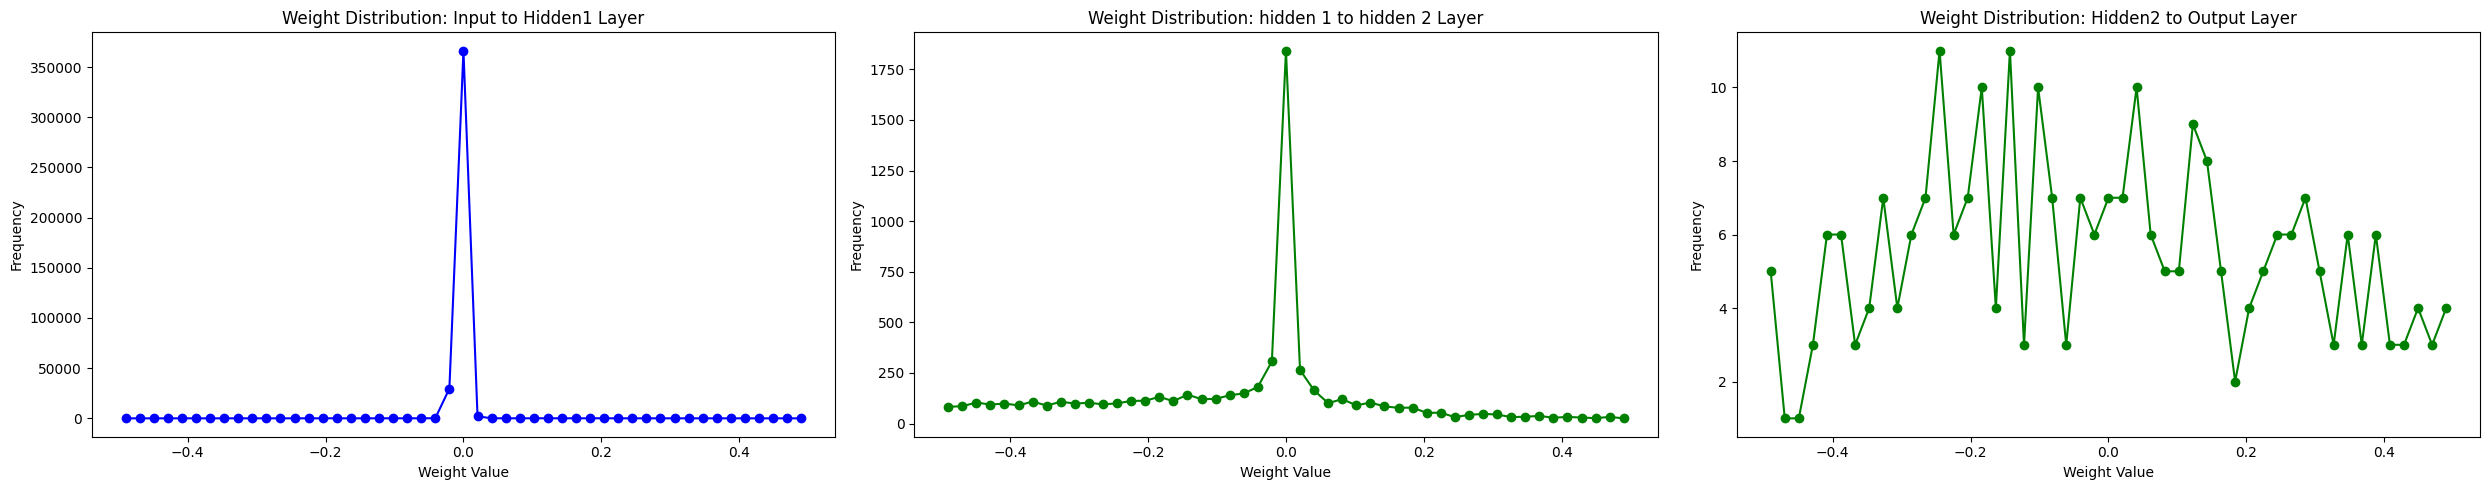

In [183]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [184]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 38510
Number of non-zero weights greater than 0.01 in layer 1: 6354
Number of non-zero weights greater than 0.01 in layer 3: 633


In [185]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[1.0050671580306518, 1.003577841839755, 0.9980686500281679, 0.9937699175681548, 0.9978539523919434, 1.0040228876344952, 1.0017214032359503, 0.9984612255469559, 0.9969199029886309, 0.9946583154117754, 1.0044992369152994, 1.0061914101392082, 0.9963600959524659, 0.9960774843809557, 0.9912589009590547, 1.0052681345366623, 1.003239924932384, 1.003697212896309, 1.006453873907993, 0.998796462189217, 1.0050328118457659, 0.9943399189254141, 1.0041193772693295, 1.0068270472579377, 0.994198501421418, 1.00427911496232, 0.9902562496598464, 0.9919845221975888, 0.9953661282287418, 1.005215249718763, 1.0031175862859756, 1.0031935797684262, 1.0051624069777014, 0.9920541897626096, 0.9971273308862747, 0.9997446221175761, 1.0056569867501384, 1.006494098006997, 1.0056021898286496, 1.0020971045757645, 1.0061144815437404, 1.0006023746411357, 0.9995753235292357, 1.005652104660388, 1.0046203261835893, 1.0010173780235754, 1.0044356960171663, 0.9943825248023005, 1.00565342564086, 0.9928106145836102, 0.9864722864

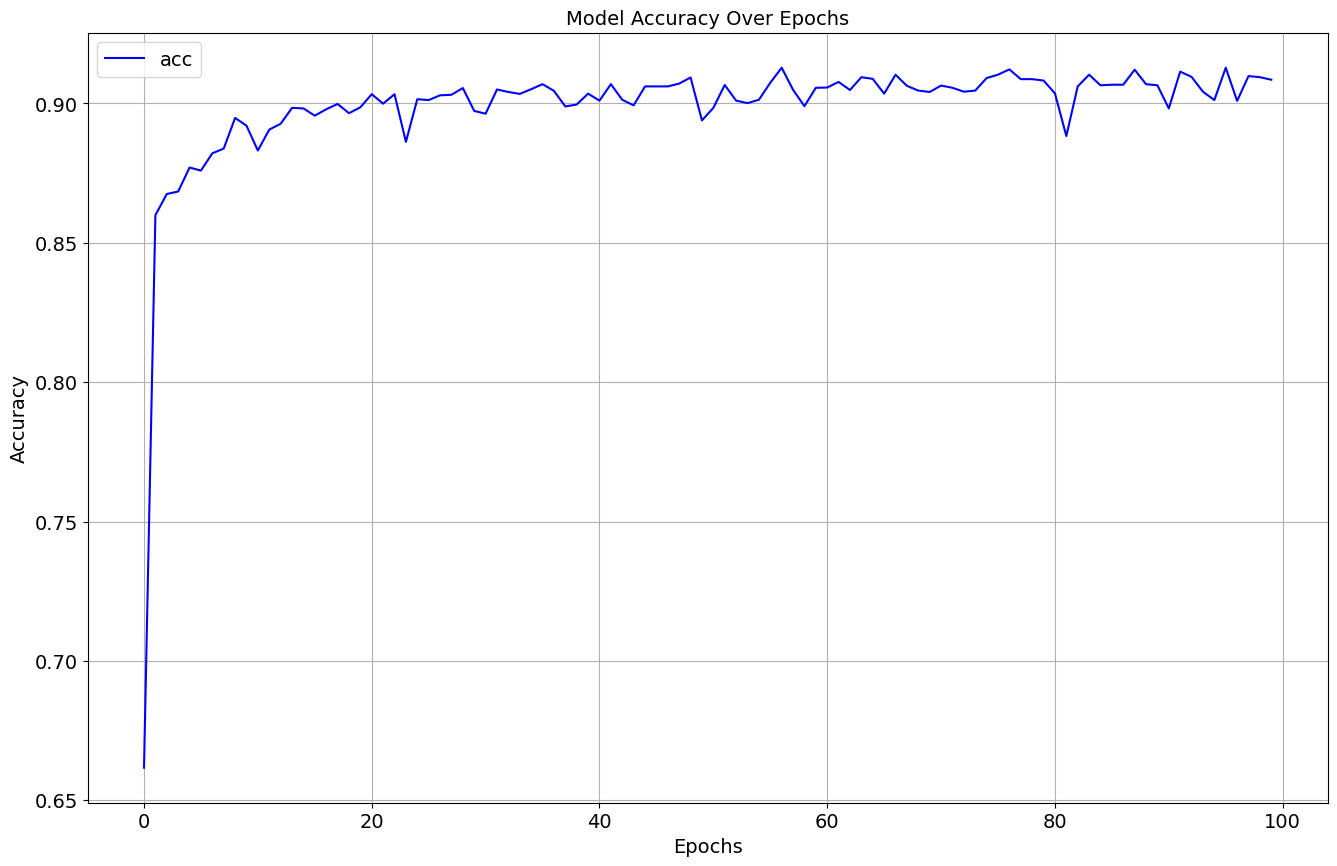

In [186]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [187]:
import pickle
with open('nbOnlineEveryEpochAcc0.pkl', 'wb') as f:
    pickle.dump(acc, f)

with open('nbOnlineEveryEpochTrainAcc0.pkl', 'wb') as f:
    pickle.dump(tacc, f)

torch.save(model.state_dict(), 'neuralBalanceModel0.pt')